# Homework 03 - Binary Leaves

Contact: David C. Schedl (david.schedl@fh-hagenberg.at)

Note: this is the starter pack for the **Digital Imaging / Computer Vision** homework. You do not need to use the exact same template and can start from scratch as well!
Using regular Python files (.py) is also possible.

# Task
<a name="Task-A" id="Task-A"> </a>

The goal of this assignment is to use binary image processing to describe and identify leaves.
You can use binary-region properties such as area, perimeter, circularity, centralized moments, and Hu moments to describe the leaves.
The `binary_leaves` dataset contains multiple images of 5 different leave types:
- Japanese maple,
- Chinese cinnamon*,
- ginkgo, maidenhair tree,
- Chinese tulip tree*, and
- tangerine.

The binary images are all of the same size, the leaves, however, are rotated and scaled slightly differently.
Furthermore, there is natural variation in the leaf shapes, which makes the task more challenging.

You can solve this task in various ways:
- Implement a hand-crafted description/threshold/rule for categorizing every leaf type.
- Use a simple machine-learning algorithm like KNN (shown below) to solve the task.
- Or, use a complex MLP with multiple layers to classify the leaves.

Whatever your solution is, evaluate how good it is by answering the following questions:
- How well can you distinguish between the different leaf types?
- Which leaves are easy to distinguish? Which are hard, and why is that?
- How many different leaf types can you distinguish?
- What are the numbers (e.g., how many percent are correctly classified)?

You don't need to use 5 different leave types.
Start with less types and add more if you feel confident.

**Hint(s):**
- You can use all the code that we used in the course as basis.
- For simplicity start with only 2 or 3 leave types and then extend 5 (leave out the leaves with *).
- When combining multiple descriptors be careful with ranges and scaling!
- When you want to use Hu moments, remember that the later moments (hu_3, hu_4, ....) are very sensitive to noise (maybe don't use them).



## Further comments/hints:
*   You do not need to come up with super efficient implementations! It is mostly about understanding the topic and the problem.
*   Think about the problem, solve it, and evaluate your solutions on the test images.
*   Summarize your ideas and solutions in the report!


**Have fun!** 😸


# Loading and working with the data

## Setup

Let's import useful libraries, first.
We'll download binary images into the `binary_leaves` folder.

In [2]:
import os
import cv2 # openCV
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd # nice tables in python


!curl -LJO "https://raw.githubusercontent.com/Digital-Media/cv_data/main/binary_leaves.zip" --silent
import zipfile
with zipfile.ZipFile("binary_leaves.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

## Loading the data

Below you can find the code to load and display the data.
For each leaf you have a binary image and a label (0 to 5) indicting the leaf type.


number of images: 282


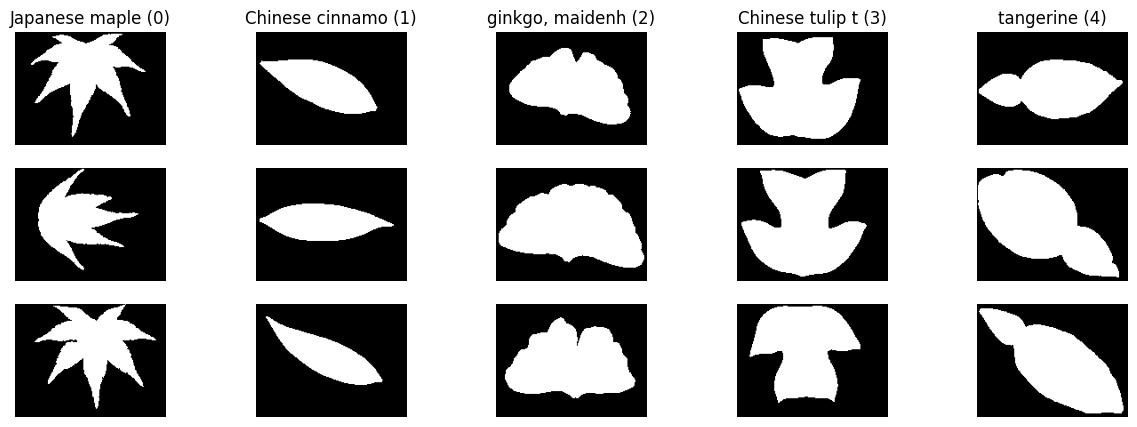

In [3]:
# Load binary leave images and labels

# load label to name mapping from json file
with open('binary_leaves/labels.json') as f:
    label_to_name = dict(json.load(f))
#print(label_to_name)

# load images and labels
images = []
labels = []
file_names = []
for label, name in label_to_name.items():
    for file in os.listdir(f'binary_leaves/{label}'):
        image = (cv2.imread(f'binary_leaves/{label}/{file}', cv2.IMREAD_GRAYSCALE)>0).astype(np.uint8)
        images.append(image)
        labels.append(label)
        file_names.append(file)

# print simple statistics
print(f'number of images: {len(images)}')

# show an example image for each class
plt.figure(figsize=(15, 5))
# init the random number generator
np.random.seed(1234)
N = 3 # number of images from the same class to show
for label, name in label_to_name.items():
    for n in range(N):
        plt.subplot(N, len(label_to_name), n*len(label_to_name) +(int(label)+1))
        # random sample from images with the same label
        idx = np.random.choice(np.where(np.array(labels)==label)[0])
        image = images[idx]
        plt.imshow(image, cmap='gray'), plt.axis('off')
        if n == 0:
            plt.title(f"{name[:15]} ({label})")
plt.show()

## Working with the dataset

Below is a simple example that shows you how to work with the dataset.
It computes properties for one leaf of each class.

In [4]:

def compute_properties(img, hu_contour=True, hu_log=True):
    """Compute properties of a binary image.
    Args:
        img (np.array): binary image
        hu_contour (bool): if True, compute the moments of the contour. Otherwise, the entire binary region is used.
        hu_log (bool): if True, compute the log of the Hu moments
    Returns:
        dict: dictionary with properties area, perimeter, circularity, and hu moments (hu_0, hu_1, ... hu_6)
    """
    # get binary regions of binary image and compute their properties (area, BBs, centroid)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    assert( len(stats) == 2 ) # foreground (1) and background (0)
    # compute the contour and its perimeter
    contour = cv2.findContours((labels==1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
    perimeter = cv2.arcLength(contour, True)

    circularity = 4.0*np.pi*stats[1,4]/ (.95*perimeter)**2

    simple_props = {'area': stats[1,4], 'perimeter': perimeter, 'circularity': circularity}

    M = cv2.moments(contour if hu_contour else (labels==1).astype(np.uint8) )

    # compute Hu moments
    hu_moments = cv2.HuMoments(M).flatten()
    if hu_log:
        hu_moments = np.sign(hu_moments) * np.log(np.abs(hu_moments)) # log is only defined for positive values, thus use abs
    hu_props = {'hu_'+str(i): hu_moments[i] for i in range(len(hu_moments))}

    return dict( **simple_props, **hu_props )



# compute properties for one examplary image
np.random.seed(1234) # init the random number generator
num_samples_per_category = 50 # change this to use more samples per category
props = {}
for label, name in label_to_name.items():
        # random sample from images with the same label
        idxs = np.random.choice(np.where(np.array(labels)==label)[0], num_samples_per_category, replace=False)
        for idx in idxs:
          image = images[idx]

          cp = compute_properties(image)
          cp.update({'label': int(label)})
          props[f"{name} ({file_names[idx]})"] = cp

# make a pandas table with the hu moments
#pd.options.display.float_format = "{:.3f}".format
df = pd.DataFrame(props)

# show the table
df

,Japanese maple (021.png),Japanese maple (044.png),Japanese maple (033.png),Japanese maple (053.png),Japanese maple (000.png),Japanese maple (029.png),Japanese maple (018.png),Japanese maple (003.png),Japanese maple (025.png),Japanese maple (050.png),...,tangerine (020.png),tangerine (019.png),tangerine (001.png),tangerine (040.png),tangerine (028.png),tangerine (007.png),tangerine (010.png),tangerine (055.png),tangerine (014.png),tangerine (039.png)
area,4987.000000,6434.000000,4157.000000,5226.000000,5911.000000,3501.000000,5391.000000,5476.000000,4575.000000,6560.000000,...,8317.000000,8787.000000,6705.000000,10975.000000,8145.000000,7719.000000,9911.000000,10696.000000,9304.000000,7072.000000
perimeter,693.411249,717.837655,632.641697,642.499562,682.239676,482.416301,646.239676,682.523947,634.541192,703.352374,...,472.457932,462.658942,416.031525,482.031525,451.931020,441.931020,477.345234,485.546244,470.658942,457.730010
circularity,0.144418,0.173857,0.144620,0.176273,0.176827,0.209465,0.179740,0.163678,0.158210,0.184638,...,0.518804,0.571586,0.539398,0.657683,0.555277,0.550319,0.605641,0.631717,0.584817,0.469987
hu_0,-1.560098,-1.596049,-1.453684,-1.532080,-1.591228,-1.572968,-1.583828,-1.565539,-1.553910,-1.575350,...,-1.341505,-1.304945,-1.421195,-1.520019,-1.420742,-1.357084,-1.514836,-1.499405,-1.340645,-1.336448
hu_1,-10.692499,-7.163483,-10.423739,-8.689431,-6.870063,-6.483024,-7.416217,-6.797743,-7.237479,-6.749861,...,-3.227236,-3.073789,-3.505253,-3.958787,-3.510709,-3.258940,-3.874935,-3.864318,-3.194438,-3.202090
hu_2,-8.028665,-8.948998,-8.743916,-7.559778,-7.828202,-8.793858,-10.375221,-8.524580,-7.529425,-8.147895,...,-6.517739,-6.987192,-6.779828,-6.579128,-7.114819,-7.207548,-7.585163,-6.747053,-6.956762,-7.091719
hu_3,-8.356436,-9.695923,-7.043566,-9.218898,-9.826733,-9.425865,-8.753179,-9.379731,-7.961152,-9.277184,...,-7.110182,-7.769556,-7.326556,-7.738171,-7.777571,-7.907988,-8.462749,-7.825673,-7.697145,-7.464417
hu_4,-16.593867,-19.079727,-15.034382,-17.637250,-18.726516,-18.542612,-18.979755,-18.364364,-15.706704,-18.304149,...,-13.924178,-15.151591,-14.379762,-14.896998,-15.223806,-15.465902,-16.487298,-15.113951,-15.024348,-14.742725
hu_5,-16.276351,13.284786,12.775085,13.663494,13.304531,12.669329,12.511239,12.778611,-11.580590,12.789681,...,-8.754321,-9.369406,-9.087626,-9.720094,-9.556036,-9.556260,-10.450793,-9.759835,-9.296310,-9.076530
hu_6,17.776558,20.097812,15.804622,-19.046091,-19.656708,-20.681811,18.471913,-19.715059,-19.482616,-18.370654,...,-18.707628,17.608136,-19.594569,18.869643,-19.926477,-19.535730,-19.856143,17.895392,-18.823661,18.563995


## Evaluation Function

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test are the true labels and y_pred are the predicted labels by your model
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return accuracy, precision, recall, f1

## Complex MLP With Multiple Layers And Confusion Matrix

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Data Preparation
with open('binary_leaves/labels.json') as f:
    label_to_name = dict(json.load(f))
#print(label_to_name)

# load images and labels
images = []
labels = []
file_names = []
for label, name in label_to_name.items():
    for file in os.listdir(f'binary_leaves/{label}'):
        image = (cv2.imread(f'binary_leaves/{label}/{file}', cv2.IMREAD_GRAYSCALE)>0).astype(np.uint8)
        images.append(image)
        labels.append(label)
        file_names.append(file)

# Flatten the images and convert labels to one-hot encoding
X = np.array([img.flatten() for img in images])
y = np.array(labels).reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Model Building

# Define a complex MLP model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_to_name), activation='softmax')
])

In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Model Training

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/25
6/6 [==============================] - 4s 469ms/step - loss: 5.3300 - accuracy: 0.2944 - val_loss: 1.8398 - val_accuracy: 0.3556
Epoch 2/25
6/6 [==============================] - 2s 384ms/step - loss: 2.7697 - accuracy: 0.4278 - val_loss: 0.5147 - val_accuracy: 0.8889
Epoch 3/25
6/6 [==============================] - 2s 322ms/step - loss: 1.8855 - accuracy: 0.6556 - val_loss: 0.4552 - val_accuracy: 0.8889
Epoch 4/25
6/6 [==============================] - 1s 226ms/step - loss: 1.2448 - accuracy: 0.7556 - val_loss: 0.5642 - val_accuracy: 0.9333
Epoch 5/25
6/6 [==============================] - 1s 222ms/step - loss: 1.1972 - accuracy: 0.7444 - val_loss: 0.6680 - val_accuracy: 0.8889
Epoch 6/25
6/6 [==============================] - 1s 221ms/step - loss: 0.8348 - accuracy: 0.7944 - val_loss: 0.5780 - val_accuracy: 0.9333
Epoch 7/25
6/6 [==============================] - 1s 219ms/step - loss: 0.2361 - accuracy: 0.9333 - val_loss: 0.4910 - val_accuracy: 0.9556
Epoch 8/25
6/6 [====

2/2 [==============================] - 0s 22ms/step


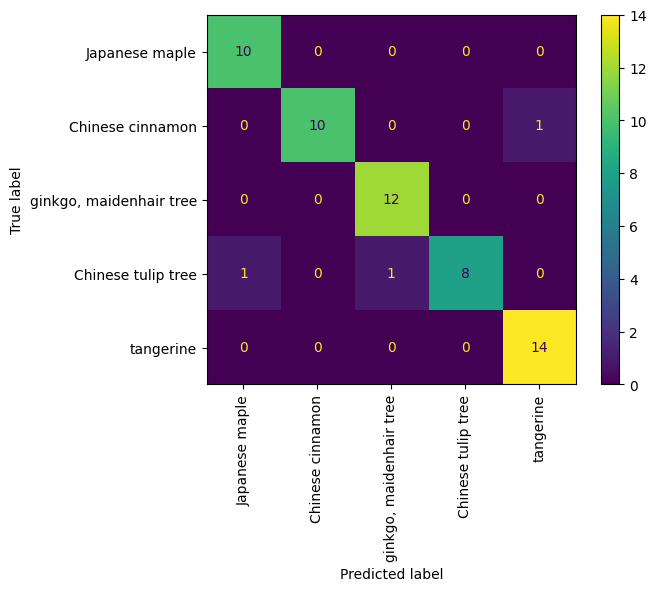

In [13]:
# Classification Metrics

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(label_to_name.values())
    )
disp.plot(xticks_rotation='vertical')
plt.show()

In [ ]:
# Training history visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [14]:
# Evaluation Function
evaluate_model(y_true_classes, y_pred_classes)

Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1-Score: 0.95


(0.9473684210526315,
 0.9514824356929621,
 0.9473684210526315,
 0.9460724608456008)

# GradientBoostingClassifier

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [24]:
def compute_properties(img, hu_contour=True, hu_log=True):
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    assert len(stats) == 2  # foreground (1) and background (0)
    contour = cv2.findContours((labels == 1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
    perimeter = cv2.arcLength(contour, True)
    circularity = 4.0 * np.pi * stats[1, 4] / (.95 * perimeter) ** 2
    simple_props = {'area': stats[1, 4], 'perimeter': perimeter, 'circularity': circularity}
    M = cv2.moments(contour if hu_contour else (labels == 1).astype(np.uint8))
    hu_moments = cv2.HuMoments(M).flatten()
    if hu_log:
        hu_moments = np.sign(hu_moments) * np.log(np.abs(hu_moments))
    hu_props = {'hu_' + str(i): hu_moments[i] for i in range(len(hu_moments))}
    return dict(**simple_props, **hu_props)


X_train shape: (200, 10)
X_test shape: (50, 10)


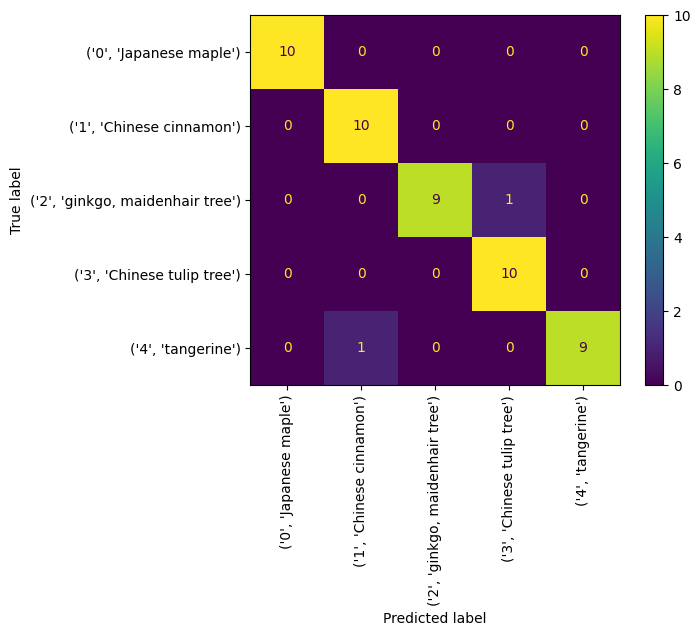

In [25]:


# Download and extract data
!curl -LJO "https://raw.githubusercontent.com/Digital-Media/cv_data/main/binary_leaves.zip" --silent
import zipfile
with zipfile.ZipFile("binary_leaves.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Load binary leave images and labels
with open('binary_leaves/labels.json') as f:
    label_to_name = dict(json.load(f))

images = []
labels = []
file_names = []
num_images_per_class = 50  # Number of images to load per class
for original_label, name in label_to_name.items():
    count = 0
    for file in os.listdir(f'binary_leaves/{original_label}'):
        if count >= num_images_per_class:
            break
        image = (cv2.imread(f'binary_leaves/{original_label}/{file}', cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)
        images.append(image)
        labels.append([original_label])
        file_names.append(file)
        count += 1

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Compute properties for each image
features = []
for img in images:
    features.append(compute_properties(img))

# Create a DataFrame from the features
df_features = pd.DataFrame(features)
df_features['label'] = labels

# Split the data into training and testing sets
X = df_features.drop(columns=['label'])
y = df_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

# Train a GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=123)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_to_name.items()
    )
disp.plot(xticks_rotation='vertical')
plt.show()


In [26]:
# Evaluation
evaluate_model(y_test, y_pred)

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-Score: 0.96


(0.96, 0.9636363636363636, 0.96, 0.9598997493734336)

# KNN

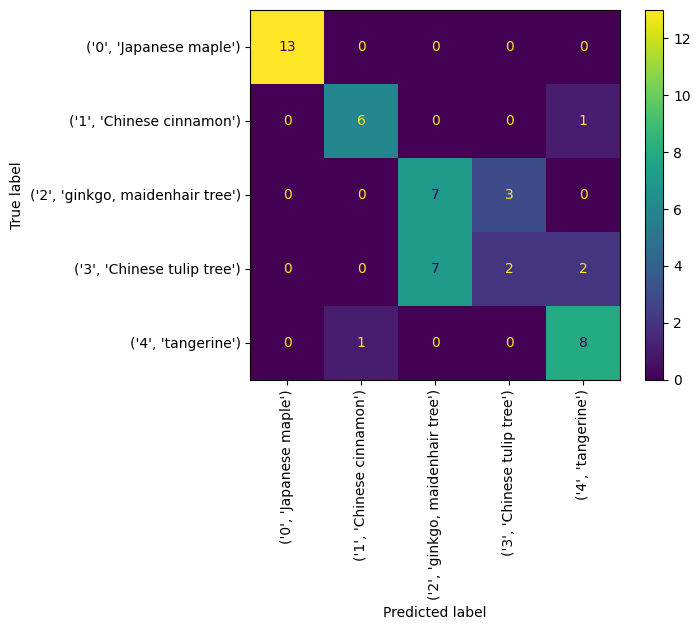

In [28]:
import os
import cv2
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Download and extract data
!curl -LJO "https://raw.githubusercontent.com/Digital-Media/cv_data/main/binary_leaves.zip" --silent
import zipfile
with zipfile.ZipFile("binary_leaves.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Load binary leave images and labels
with open('binary_leaves/labels.json') as f:
    label_to_name = dict(json.load(f))

# load images and labels
images = []
labels = []
file_names = []
for label, name in label_to_name.items():
    for file in os.listdir(f'binary_leaves/{label}'):
        image = (cv2.imread(f'binary_leaves/{label}/{file}', cv2.IMREAD_GRAYSCALE)>0).astype(np.uint8)
        images.append(image)
        labels.append(label)
        file_names.append(file)

# Define the compute_properties function
def compute_properties(img, hu_contour=True, hu_log=True):
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    assert len(stats) == 2  # foreground (1) and background (0)
    contour = cv2.findContours((labels == 1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
    perimeter = cv2.arcLength(contour, True)
    circularity = 4.0 * np.pi * stats[1, 4] / (0.95 * perimeter) ** 2
    simple_props = {'area': stats[1, 4], 'perimeter': perimeter, 'circularity': circularity}
    M = cv2.moments(contour if hu_contour else (labels == 1).astype(np.uint8))
    hu_moments = cv2.HuMoments(M).flatten()
    if hu_log:
        hu_moments = np.sign(hu_moments) * np.log(np.abs(hu_moments))
    hu_props = {'hu_' + str(i): hu_moments[i] for i in range(len(hu_moments))}
    return dict(**simple_props, **hu_props)

np.random.seed(1234) # init the random number generator
num_samples_per_category = 4 # change this to use more samples per category
props = {}
for label, name in label_to_name.items():
        # random sample from images with the same label
        idxs = np.random.choice(np.where(np.array(labels)==label)[0], num_samples_per_category, replace=False)
        for idx in idxs:
          image = images[idx]

          cp = compute_properties(image)
          cp.update({'label': int(label)})
          props[f"{name} ({file_names[idx]})"] = cp

# make a pandas table with the hu moments
#pd.options.display.float_format = "{:.3f}".format
df = pd.DataFrame(props)

# Split the data into training and testing sets
X = df_features.drop(columns=['label'])
y = df_features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate the classifier
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_to_name.items()
    )
disp.plot(xticks_rotation='vertical')
plt.show()


In [29]:
# Evaluate Model
evaluate_model(y_test, y_pred)

Accuracy: 0.72
Precision: 0.70
Recall: 0.72
F1-Score: 0.70


(0.72, 0.6989090909090909, 0.72, 0.6956666666666667)